# Projet Apprentisage Statistique

<b>M2 TIDE </b> <br>
<b> 2021-2022 </b>  <br>
<b> <u>Groupe</u> : Laurène DAVID, Safa Hamdan, Allan Pendant</b> 

## Introduction
Dans ce projet, nous allons présenter et implémenter en python les <b>méthodes de Prédiction</b> (LASSO, Arbre CART, Random Forest,...) et une méthode de Clustering (GMM) vues pendant le cours d'Apprentisage Statistique. <br>


Nous allons d'abord importer les librairies ainsi que les datsets qui vont nous servir à construire ce projet.

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style("whitegrid")

In [2]:
covid = pd.read_csv("Covidcases.csv")
housing = pd.read_csv("ParisHousing.csv")

<br>
Nous allons commencer par nettoyer les données <i>ParisPriceHousing</i>
Certaines variables nécessitent d'être transformé pour rendre le dataset exploitable

- "numberOfRooms" est composé des strings qui correspondent à des chiffres (chiffres en texte -> valeurs numériques)
- "hasStormProtector", "hasStoargeRoom" et "isNewBuilt" sont des variables composées de booléans (True/False à transformer en Vrai/Faux)
- "category" et "PoolAndYard" sont des variables de types object qui doivent être transformé en variables booléennes (O ou 1)


In [10]:
#transformation des variables True/False en variables 0/1
columns_bool = housing.select_dtypes(bool).columns
housing[columns_bool]  = housing.select_dtypes(bool).apply(lambda x : x.astype(int))


#transformation de la variable "numberOfRooms" de type string
from word2number import w2n 
housing['numberOfRooms'] = housing['numberOfRooms'].apply(lambda x : w2n.word_to_num(x))


#transformation de la variable 'PoolAndYard' 
housing['hasPool'] = housing['PoolAndYard'].str[:8]
housing['hasYard'] = housing['PoolAndYard'].str[12:]
housing.drop(columns = ['PoolAndYard'], inplace = True)

housing['hasPool'] = housing['hasPool'].apply(lambda x : 1 if 'has' in x else 0)
housing['hasYard'] = housing['hasYard'].apply(lambda x : 1 if 'has' in x else 0)


#OneHotEncoding sur les variables multi-catégorielles
from sklearn.preprocessing import OneHotEncoder

OneHot = OneHotEncoder(sparse=False) 
new_ = OneHot.fit_transform(housing['category'].values.reshape(-1,1))
feature_names = OneHot.get_feature_names(input_features=['category']) 
housing[feature_names] = pd.DataFrame(new_, columns =  (feature_names))

housing.drop(columns = ['category', 'Unnamed: 0'], inplace = True)

<br>
<br>

# Prédiction par LASSO (Par Laurène David)

## LASSO

Le principe du <b>LASSO</b> est d'ajouter une contrainte supplémentaire à la régression classique qui vise à rendre le vecteur des paramètres estimées "sparse". Il se base sur l'hypothèse qu'il existe, en réalité, un certain nombre de coefficients nuls dans notre paramètre et permet de retrouver le "support" du vecteur $\theta$, soit l'ensemble des ces coefficients non nuls. Le LASSO utilise la norme $||.||_1$ pour régulariser la taille du vecteur $\theta$ pour remplacer la norme $||.||_0$ qui ne permet pas d'obtenir un problème solvable.

Le <b>problème d'optimisation</b> associé à la régression s'écrit alors :
$$\frac{1}{n}\sum_{i = 1}^{n}(Y_{i} - \mathbf{X}\theta)^2 + \lambda||\theta||_{1}$$

avec $\lambda$ le paramètre de régularisation. 

<br>
Nous allons d'abord présenter <b>l'effet de sparsity</b> que le LASSO a sur le paramètre $\theta$ de la régression linéaire.
Dans un second temps, nous allons chercher à estimer le paramètre de régularisation $\theta$ optimale pour la régression. <br>
<br>

<b> Préparation des données </b> : <br>
Création des train/test split et Standardisation des données

In [11]:
#construction X et Y
y_paris = housing['numberOfRooms']
x_paris = housing.drop(columns = ['numberOfRooms', 'cityCode'])

#standardisation des données
from sklearn.preprocessing import StandardScaler
x_paris[['squareMeters','basement','attic', 'garage', 'price']] = StandardScaler().fit(x_paris[['squareMeters','basement','attic', 'garage', 'price']]).transform(x_paris[['squareMeters','basement','attic', 'garage', 'price']])

#construction train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_paris, y_paris, test_size=0.33, random_state=1)

<br>
<b> Régression Linéaire classique (sans régularisation) </b> <br>
Nous allons commencer par estimer le paramètre $\theta$ d'une régression linéaire classique.

In [12]:
from sklearn.linear_model import LinearRegression

reg_log = LinearRegression().fit(x_train,y_train)
reg_coef = reg_log.coef_
reg_predict = reg_log.predict(x_test)
reg_coef_df = pd.DataFrame({'var':x_train.columns, 'coef':np.round(reg_coef,3)})


print(reg_coef_df.loc[reg_coef_df['coef'] != 0.000,:].reset_index(drop = True))
print("")
print(f"Pourcentage coefficients non nuls: {100*len(reg_coef_df.loc[reg_coef_df['coef'] != 0,:])/len(reg_coef_df):.0f}%")

                  var     coef
0        squareMeters  526.019
1              floors    0.032
2       cityPartRange    0.153
3       numPrevOwners    0.236
4                made   -0.009
5          isNewBuilt    0.077
6   hasStormProtector    0.088
7            basement   -0.170
8               attic    0.232
9              garage    0.704
10     hasStorageRoom   -0.975
11       hasGuestRoom   -0.184
12              price -526.155
13            hasPool    0.523
14            hasYard    0.160
15     category_Basic   -0.471
16    category_Luxury    0.471

Pourcentage coefficients non nuls: 100%


<br>
<b> Régression Linéaire par LASSO (avec régularisation) </b> <br>
Nous allons maintenant estimer les coefficients de $\theta$ par un LASSO avec le paramètre de régularisation fixé à 1.

In [13]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 1).fit(x_train, y_train)
lasso_reg_coef = lasso_reg.coef_
lasso_reg_predict = lasso_reg.predict(x_test)
lasso_df = pd.DataFrame({'var':x_train.columns, 
                         'coef':np.round(lasso_reg_coef,3)})

print('Régression avec régularisation (lambda = 1):')
print('')
print('Coefficients non nuls :')
print(lasso_df.loc[lasso_df['coef'] != 0.000,:].reset_index(drop = True))
print('')
print(f"Pourcentage coefficients non nuls: {100*len(lasso_df.loc[lasso_df['coef'] != 0,:])/len(lasso_df):.0f}%")

Régression avec régularisation (lambda = 1):

Coefficients non nuls :
             var   coef
0         floors  0.022
1  cityPartRange  0.026
2  numPrevOwners  0.111
3   hasGuestRoom -0.090

Pourcentage coefficients non nuls: 24%


Le LASSO a donc permis de construire un paramètre $\theta$ sparse qui passe de 100% de coefficients non nuls à 24%. <br>
Il a permis de réduire à zero les coefficients qui ne sont en réalité pas significatifs pour le modèle. Dans cette prochaine partie, nous allons expliquer comment estimer le meilleur paramètre pour $\lambda$, c'est-à-dire celui qui fait le meilleur compromis entre l'ajustement des données et la régularisation du paramètre $\theta$.

<br>
<b> Choix du paramètre $\lambda$ optimal </b> <br> 
Le choix du paramètre $\lambda$ est très important lorsqu'on cherche à prédire avec le LASSO. <br> 
Le paramètre calibre <b>l'influence de la régularisation</b> dans le modèle. 

- Si on choisit une valeur trop grande pour $\lambda$, on court le risque d'estimer un vecteur $\theta$ nul et de faire du <b>sous-apprentissage</b>. Le poids accordé à la régularisation est alors trop important. <br>
- Si la valeur de $\lambda$ est trop faible, on risque de garder trop de covariables pour notre modèle et de faire du <b>sur-apprentissage</b>. 

Nous allons utiliser une version itérative de la fonction <i>LASSO</i> de scikit learn qui détermine par cross-validation le paramètre $\lambda$ optimal. La méthode de cross-validation que nous allons utilisé est la <b> V-fold Cross Validation </b> (<i>K-fold</i> sur sklearn) avec V = 5 pour estimer l'erreur qudratique moyen.<br> 

In [14]:
from sklearn.linear_model import LassoCV

#vecteur des paramètres lambda 
lambda_ = np.arange(0.01,6,0.01)

#lasso avec different param lambda
mse_lasso = LassoCV(cv=5, max_iter = 500, alphas = lambda_, n_alphas = len(lambda_), random_state=0).fit(x_train, y_train)

#df avec 5 splits
mse_df = pd.DataFrame(mse_lasso.mse_path_, columns = ['split ' + str(i) for i in range(1,6)])
mse_df['lambda'] = lambda_
print(mse_df.head(5))

      split 1     split 2     split 3     split 4     split 5  lambda
0  823.613592  831.891758  813.213422  862.440150  823.724308    0.01
1  823.614011  831.890785  813.213508  862.440351  823.723876    0.02
2  823.614431  831.889812  813.213594  862.440553  823.723444    0.03
3  823.614851  831.888840  813.213681  862.440754  823.723012    0.04
4  823.615271  831.887868  813.213768  862.440956  823.722580    0.05


Nous allons ensuite faire la moyenne pour chaque lambda des 5 erreurs calculées.
<br>

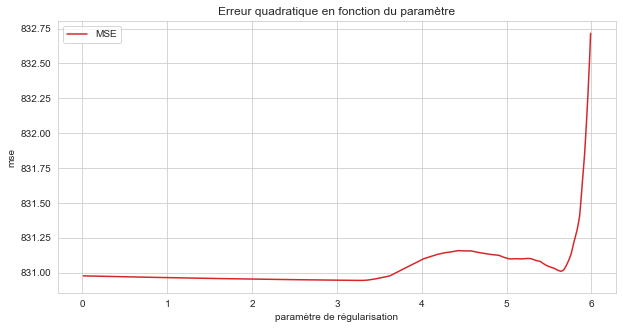

In [15]:
lambda_error_ = mse_df.iloc[:,:5].mean(axis=1)
lambda_df = pd.DataFrame({'lambda':lambda_, 'error':lambda_error_})
lambda_min = lambda_df.loc[lambda_df['error'] == np.min(lambda_df['error']),'lambda'].to_list()[0]

plt.figure(figsize = (10,5));
plt.plot(lambda_ , lambda_error_, label = "MSE", color = 'tab:red')
plt.xlabel('paramètre de régularisation')
plt.ylabel('mse')
plt.title("Erreur quadratique en fonction du paramètre");
plt.legend();
plt.show()

L'erreur quadratique moyen semble se minimiser entre $\lambda = 3$ et $\lambda = 4$. <br>
Nous allons aggrandir l'échelle pour mieux visualiser le minimum.

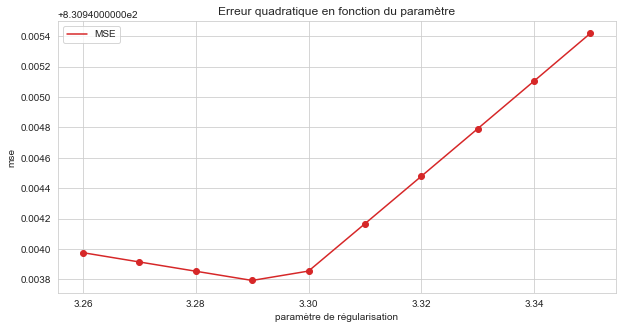


L'erreur quadratique moyen est minimisé pour lambda = 3.29.


In [16]:
plt.figure(figsize = (10,5));
plt.plot(lambda_df.loc[(lambda_df['lambda'] > 3.25) & (lambda_df['lambda'] < 3.35),"lambda"], 
         lambda_df.loc[(lambda_df['lambda'] > 3.25) & (lambda_df['lambda'] < 3.35),"error"], 
         label = "MSE", 
         color = 'tab:red')
plt.scatter(lambda_df.loc[(lambda_df['lambda'] > 3.25) & (lambda_df['lambda'] < 3.35),"lambda"], 
            lambda_df.loc[(lambda_df['lambda'] > 3.25) & (lambda_df['lambda'] < 3.35),"error"], 
            color = 'tab:red')

plt.xlabel('paramètre de régularisation')
plt.ylabel('mse')
plt.title("Erreur quadratique en fonction du paramètre");
plt.legend();
plt.show()
print("")
print(f"L'erreur quadratique moyen est minimisé pour lambda = {lambda_min}.")

<br>
<b> Implémentation du LASSO </b> <br>
La méthode du 5-fold cross validation nous a donné comme paramètre de régularisation $\lambda = 3.29$. <br>
Nous allons donc fixer le paramètre <i>alpha</i> à 3.29 pour construire notre LASSO.

In [18]:
from sklearn.linear_model import Lasso

lasso_opt = Lasso(alpha = 3.29).fit(x_train, y_train)
theta_opt = lasso_opt.coef_
predict_opt = lasso_opt.predict(x_test)

#support du parmaètre theta 
opt_lasso_coef_df = pd.DataFrame({'variable':x_train.columns,
                              'coef':np.round(theta_opt,4)})

print('Résultat du LASSO :')
print('')
print('Coefficients non nuls:')
print(opt_lasso_coef_df.loc[opt_lasso_coef_df['coef'] != 0.000,:].reset_index(drop = True))
print('')
print(f"Le support du paramètre theta est donc {[opt_lasso_coef_df.loc[opt_lasso_coef_df['coef'] != 0.000,:]['coef'][1]]}")

Résultat du LASSO :

Coefficients non nuls:
  variable    coef
0   floors  0.0192

Le support du paramètre theta est donc [0.0192]


<br>
<b> Comparaison des trois régressions (problème de shrinkage) : </b>

In [19]:
comp_lasso = pd.DataFrame({'Régression classique': reg_coef, 
                           'LASSO (reg = 1)' : lasso_reg_coef, 
                           'LASSO (reg = 3.29)': theta_opt})

comp_lasso.index = x_train.columns
print(comp_lasso)
print("")
#MSE de chaque régression
from sklearn.metrics import mean_squared_error
print(f"MSE Régression classique : {np.round(mean_squared_error(y_test,reg_predict),2)}")
print(f"MSE LASSO (reg = 1): {np.round(mean_squared_error(y_test,lasso_reg_predict),2)}"),
print(f"MSE LASSO (reg = 3.29): {np.round(mean_squared_error(y_test,predict_opt),2)}")

                   Régression classique  LASSO (reg = 1)  LASSO (reg = 3.29)
squareMeters                 526.018514        -0.000000           -0.000000
floors                         0.032445         0.021659            0.019164
cityPartRange                  0.152776         0.025811            0.000000
numPrevOwners                  0.236407         0.111201            0.000000
made                          -0.008857        -0.000000           -0.000000
isNewBuilt                     0.077344         0.000000            0.000000
hasStormProtector              0.088418         0.000000            0.000000
basement                      -0.169637        -0.000000           -0.000000
attic                          0.232454         0.000000            0.000000
garage                         0.704348         0.000000            0.000000
hasStorageRoom                -0.974502        -0.000000           -0.000000
hasGuestRoom                  -0.184179        -0.089996           -0.000000

Plus la paramètre de régularisation est élevé, plus le nombre de coefficients non nuls diminiue. <br>
Pour le LASSO optimal, il ne reste plus qu'un seul coefficient non nul. <br>

Le LASSO a tout de même permis de réduire l'erreur quadratique moyen de la régression sur la base test, il permet donc d'améliorer la performance de la régression linéaire classique qui peut souffrir du sur-apprentissage. <br>

Cependant, le LASSO a tendance à sous-estimer les coefficients de la régression.
Nous verrons dans une prochaine partie comment corriger ce problème grâce à l'Adaptive-LASSO.La performance du LASSO peut aussi être affecté par la présence de covariables corréles. 
Nous verrons comment des modèles comme le GROUP-LASSO et l'Elastic Net permettent d'apporter une solution aux problèmes de corrélation des covariables.
<br>
<br>

## Adaptive-LASSO

L'Adaptive-LASSO est une variante du LASSO qui cherche à répondre au problème de <i>Shrinkage</i>. Elle se base sur la méthode de régularisation du LASSO mais cherche à construire un estimateur de la norme $||.||_0$ au lieu d'utiliser la norme $||.||_1$. 

$$ ||\theta||_0 \approx \sum_{j = 1}^{d}\frac{|\theta_j|}{|\tilde{\theta_j}|}\mathbb{1}_{\tilde{\theta_j} \ne 0}$$

Le problème d'optimisation devient :
$$ min_{\theta \in \mathbb{R}^d} ~ ||Y - X\theta||_n^2 + \lambda\sum_{j = 1}^{d}w_j|\theta_j|$$

Les coefficients $\theta_j$ sont pondérés par les poids $w_j = \frac{1}{|\tilde{\theta}_j|}$.
- si le paramètre estimé $\tilde{\theta}_j$ est grand, alors le poids $w_j$ devient petit et donc le coefficient $\theta_j$ peut prendre une grande valeur
- si le paramètre estimé $\tilde{\theta}_j$ est petit, alors le poids $w_j$ devient grand et donc le coefficient $\theta_j$ prend une faible valeur pour satisfaire la minimisation

<br>
<b> Poids $w_j$ des coefficients </b> <br>
Pour construire les poids $w_j$, nous allons utiliser une régression par moindres carrés ordinaires (OLS estimator) et utiliser les coefficients $\tilde{\theta}_j$ de l'estimation. 


In [20]:
OLS_estimator = sm.OLS(y_train, x_train).fit()
print(OLS_estimator.params.to_numpy())

[ 5.26018514e+02  3.24452620e-02  1.52776180e-01  2.36406762e-01
 -8.85705448e-03  7.73442278e-02  8.84180937e-02 -1.69637442e-01
  2.32453676e-01  7.04348480e-01 -9.74501568e-01 -1.84179350e-01
 -5.26154506e+02  5.23331443e-01  1.59850934e-01  6.50476419e+01
  6.59888399e+01]


Ces coefficients nous permettent d'estimer le poids de chaque variable.

In [21]:
OLS_params = OLS_estimator.params.to_numpy()
vect_1 = np.full((1,len(OLS_params)),1)

poids_ = pd.Series(abs(np.divide(vect_1, OLS_params).flatten()))
poids_.index = x_train.columns

print("Poids des coefficients:")
print("")
print(poids_)

Poids des coefficients:

squareMeters           0.001901
floors                30.821141
cityPartRange          6.545523
numPrevOwners          4.229997
made                 112.904352
isNewBuilt            12.929213
hasStormProtector     11.309902
basement               5.894925
attic                  4.301932
garage                 1.419752
hasStorageRoom         1.026166
hasGuestRoom           5.429490
price                  0.001901
hasPool                1.910835
hasYard                6.255828
category_Basic         0.015373
category_Luxury        0.015154
dtype: float64


Nous n'avons pas réussi à trouver de librairie Python qui permet d'implementer l'Adaptive-LASSO (le modèle n'étant pas disponible sur sklearn). <br>
Nous nous sommes donc contenté d'estimer les poids qui vont servir à construire un estimateur de la norme $||.||_0$
<br>
<br>

## RIDGE

La régression RIDGE est une autre méthode de régression linéaire avec régularisation. <br>
Contrairement au LASSO, le RIDGE utilise la norme $||.||_2$ pour régulariser le paramètre $\theta$  <br>

$$ min_{\theta \in \mathbb{R}^d} ~ ||Y - X\theta||_n^2 + \lambda||\theta||_2^2$$

avec $||\theta||_n^2 = \sum_{i=1}^{n}\theta_i^2/n$

La régression RIDGE souffre aussi du problème du <i>Shrinkage</i> mais celui-ci reste moins important que pour le LASSO. <br>
Cependant, le RIDGE ne permet de faire de la sélection de variable car il ne construit pas un vecteur $\theta$ sparse.

In [22]:
#construction X et Y
y_paris = housing['price']
x_paris = housing.drop(columns = ['price','cityCode'])

#construction train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_paris, y_paris, test_size=0.33, random_state=1)

<br>
<b> Choix le paramètre $\lambda$ optimal </b>: <br>
Dans cette première partie, nous allons déterminer le meilleur paramètre de régularisation pour le Ridge. <br>
Comme pour le LASSO, nous allons estimer les erreurs du modèle grâce à un <b>5-fold Cross Validation</b>
Nous allons chercher le paramètre $\lambda$ qui minimise l'erreur quadratique moyen du test split. <br>

Le choix du paramètre $\lambda$ est important car il permet de maintenir l'equilibre entre une bonne prédiction et la régularisation du paramètre.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

dict_params = {'alpha':np.arange(0.1,1,0.1)}
kfold = KFold(n_splits=5)

grid_search_ridge = GridSearchCV(Ridge(), param_grid = dict_params, cv = kfold, scoring = 'neg_mean_squared_error').fit(x_paris,y_paris)
params_ = [grid_search_ridge.cv_results_['params'][i]['alpha'] for i in range(0, len(grid_search_ridge.cv_results_['params']))]

grid_ridge_df = pd.DataFrame({'split 1': - grid_search_ridge.cv_results_['split0_test_score'], 
                              'split 2': - grid_search_ridge.cv_results_['split1_test_score'], 
                              'split 3': - grid_search_ridge.cv_results_['split2_test_score'], 
                              'split 4': - grid_search_ridge.cv_results_['split3_test_score'], 
                              'split 5': - grid_search_ridge.cv_results_['split4_test_score'], 
                              'lambda':params_})

print('Erreur quadratique moyen pour chaque split:')
print("")
print(grid_ridge_df.head(5).to_string(index=False))

Erreur quadratique moyen pour chaque split:

     split 1      split 2      split 3      split 4      split 5  lambda
3.908841e+06 3.639893e+06 3.395673e+06 3.444473e+06 3.681082e+06     0.1
3.908848e+06 3.639897e+06 3.395678e+06 3.444470e+06 3.681069e+06     0.2
3.908854e+06 3.639901e+06 3.395683e+06 3.444467e+06 3.681056e+06     0.3
3.908861e+06 3.639905e+06 3.395688e+06 3.444465e+06 3.681043e+06     0.4
3.908867e+06 3.639908e+06 3.395693e+06 3.444462e+06 3.681031e+06     0.5


<br>
Nous allons faire la moyenne des 5 splits pour chaque $\lambda$ afin de tracer la courbe des erreurs.

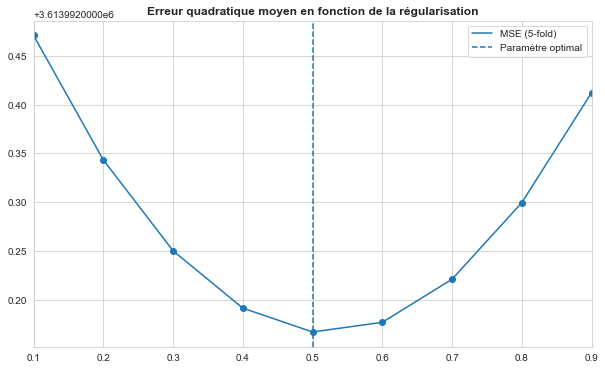

Erreur quadratique minimisé pour lambda = 0.5


In [24]:
grid_ridge_mean = pd.DataFrame({'lambda':np.arange(0.1,1,0.1),
                                'error':grid_ridge_df.iloc[:,:5].mean(axis=1)})

plt.figure(figsize=(10,6))
plt.title("Erreur quadratique moyen en fonction de la régularisation", fontweight = 'bold');
plt.plot(grid_ridge_mean['lambda'], grid_ridge_mean['error'], label = 'MSE (5-fold)');
plt.scatter(grid_ridge_mean['lambda'], grid_ridge_mean['error']);
plt.xlim((0.1,0.9));
plt.axvline(0.5, linestyle = '--', label = 'Paramètre optimal');
plt.legend();
plt.show()

lambda_min = np.round(grid_ridge_mean.loc[grid_ridge_mean['error'] == min(grid_ridge_mean['error']),"lambda"].to_numpy()[0],2)
print(f"Erreur quadratique minimisé pour lambda = {lambda_min}")

<br>
<b> Implémentation du RIDGE :</b> <br>
Nous allons implémenter une régression RIDGE avec $\lambda = 0.3$.

In [25]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha = 0.5, random_state = 1).fit(x_train,y_train)
linear_model = LinearRegression().fit(x_train,y_train)
ridge_coef = pd.DataFrame({'variable':x_paris.columns, 
                           'RIDGE':np.round(ridge_model.coef_,3), 
                           'Régression':np.round(linear_model.coef_,3)})
print(ridge_coef)
print("")
print(f"MSE Régression: {np.round(mean_squared_error(y_test,linear_model.predict(x_test)),0)}")
print(f"MSE RIDGE: {np.round(mean_squared_error(y_test,ridge_model.predict(x_test)),0)}")

             variable     RIDGE  Régression
0        squareMeters   100.000     100.000
1       numberOfRooms    -0.794      -0.794
2              floors    54.762      54.762
3       cityPartRange    40.380      40.376
4       numPrevOwners    -0.324      -0.321
5                made    -3.057      -3.056
6          isNewBuilt   139.221     139.754
7   hasStormProtector   119.415     119.475
8            basement    -0.007      -0.007
9               attic    -0.006      -0.006
10             garage     0.105       0.105
11     hasStorageRoom    30.438      30.454
12       hasGuestRoom    -9.364      -9.362
13            hasPool  2962.810    2964.153
14            hasYard  3054.108    3055.474
15     category_Basic    42.026      42.968
16    category_Luxury   -42.026     -42.968

MSE Régression: 3611583.0
MSE RIDGE: 3611560.0


Nous pouvons voir que le RIDGE n'a pas construit de paramètre sparse mais à légèrement réduit la valeur des coefficients dans la majorité des cas (par rapport à une régression classique). Il a aussi permis d'améliorer la performance de la régression sur la base test. Le RIDGE est donc un modèle utile pour réduire le risque du sur-apprentissage. 
<br>
<br>

## Elastic Net

L'Elastic Net est une variante du LASSO qui cherche à améliorer le LASSO lorsqu'il existe de la dépendance entre les covariables étudiées. L'Elastic Net apprend par lui-même à regrouper les variables dépendantes (contrairement au Group-LASSO qui nécessite de connaître en amount les groupes).

L'Elastic Net combine les méthodes du LASSO et du RIDGE et introduit les normes $||.||_1$ et $||.||_2$ au problème d'optimisation. <br>

$$||\mathbf{Y} - \mathbf{X}\theta||_n^{2} + \lambda(\alpha||\theta||_1 + (1 - \alpha)\frac{1}{2}||\theta||_2^{2})$$

- $\alpha$ contrôle le poids du LASSO et du RIDGE dans le modèle. <br>
- $\lambda$ contrôle la régularisation général du paramètre

Nous allons utiliser le dataset <i>ParisPriceHousing</i> et les train/test split utilisés dans la partie du Ridge pour implémenter l'ElasticNet.
<br>

<b> Choix des paramètres $\alpha$ et $\lambda$ </b> : <br>
Nous allons maintenant estimer les paramètres $\alpha$ et $\lambda$ par une 5-fold Cross Validation avec la fonction <i>ElasticNetCV</i> 

In [26]:
from sklearn.linear_model import ElasticNetCV

l1_ratio_list = np.arange(0.01,1,0.01) #alpha
alphas_list = np.arange(0.01,3,0.01) #lambda

el_cv = ElasticNetCV(l1_ratio = l1_ratio_list, 
                     alphas = alphas_list, 
                     n_alphas = len(alphas_list), 
                     cv = 5, 
                     random_state = 1).fit(x_paris,y_paris)

print("Meilleures paramètres de l'Elastic Net :")
print(f"Lambda: {el_cv.alpha_}")
print(f"Alpha: {el_cv.l1_ratio_}")

Meilleures paramètres de l'Elastic Net :
Lambda: 0.02
Alpha: 0.99


L'Elastic Net a estimé le paramètre $\alpha$ à 0.99. Nous pouvons en déduire que la contribution de la régularisation du RIDGE dans le modèle est extremement faible. Notre modèle d'Elastic Net s'approche donc beaucoup d'une régression LASSO.

Pour comprendre comment <i>ElasticNetCV</i> à choisi ces paramètres, nous allons tracer l'erreur quadratique moyen en fonction de $\lambda$ en fixant $\alpha = 0.1$

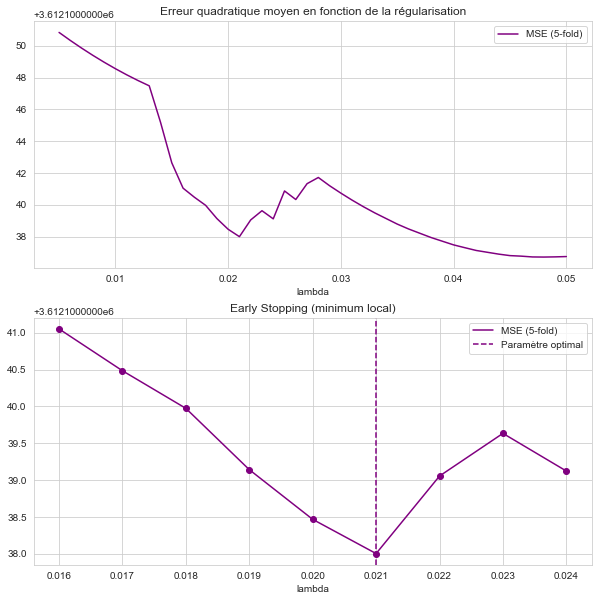

Choix du paramètre lambda = 0.021


In [27]:
from sklearn.linear_model import ElasticNet
dict_params = {'alpha':np.arange(0.005,0.05,0.001)}
kfold = KFold(n_splits=5)

grid_search_el = GridSearchCV(ElasticNet(l1_ratio = 0.99), 
                              param_grid = dict_params, 
                              cv = kfold, 
                              scoring = 'neg_mean_squared_error').fit(x_train,y_train)

grid_el_df = pd.DataFrame({'split 1': - grid_search_el.cv_results_['split0_test_score'], 
                              'split 2': - grid_search_el.cv_results_['split1_test_score'], 
                              'split 3': - grid_search_el.cv_results_['split2_test_score'], 
                              'split 4': - grid_search_el.cv_results_['split3_test_score'], 
                              'split 5': - grid_search_el.cv_results_['split4_test_score'], 
                              'lambda':np.arange(0.005,0.05,0.001)})

grid_el_mean = pd.DataFrame({'lambdas':np.arange(0.005,0.05,0.001),
                                'error':grid_el_df.iloc[:,:5].mean(axis=1)})

plt.figure(figsize=(10,10))

#graph1
plt.subplot(2,1,1);
plt.title("Erreur quadratique moyen en fonction de la régularisation");
plt.plot(grid_el_mean['lambdas'], grid_el_mean['error'], label = 'MSE (5-fold)', color = 'purple');
plt.xlabel('lambda');
plt.legend();

#graph2
plt.subplot(2,1,2);
plt.plot(grid_el_mean.loc[(grid_el_mean['lambdas'] > 0.015) & (grid_el_mean['lambdas'] < 0.025),"lambdas"], 
         grid_el_mean.loc[(grid_el_mean['lambdas'] > 0.015) & (grid_el_mean['lambdas'] < 0.025),"error"], 
         label = 'MSE (5-fold)',
         color = 'purple');
plt.scatter(grid_el_mean.loc[(grid_el_mean['lambdas'] > 0.015) & (grid_el_mean['lambdas'] < 0.025),"lambdas"], 
            grid_el_mean.loc[(grid_el_mean['lambdas'] > 0.015) & (grid_el_mean['lambdas'] < 0.025),"error"], 
            color ='purple');
plt.title("Early Stopping (minimum local)")
plt.axvline(0.021, linestyle = '--', label = 'Paramètre optimal', color = 'purple');
plt.xlabel('lambda');
plt.legend();
plt.show()

print(f"Choix du paramètre lambda = 0.021")

La fonction <i>ElasticNetCV</i> a donc choisi le paramètre $\lambda$ grâce à la méthode du <b>Early Stopping</b>. <br>
Le principe du Early Stopping est de choisir le paramètre de régularisation au niveau du premier minimum local atteint par l'erreur quadratique moyen. Dans de nombreux algorithmes itératifs, l'erreur décroit jusqu'à ce que le modèle commence à "over-fitter" les données.



<b>Régularization Path</b> : <br>
Avant d'implementer l'Elastic Net, nous allons tracer sa "Régularization Path". <br>
Nous avons choisi un nombre restreint de variables (5) pour tracer le graph puisque certains coefficients estimées sont très élevées et rendent le graph difficile à interpréter.

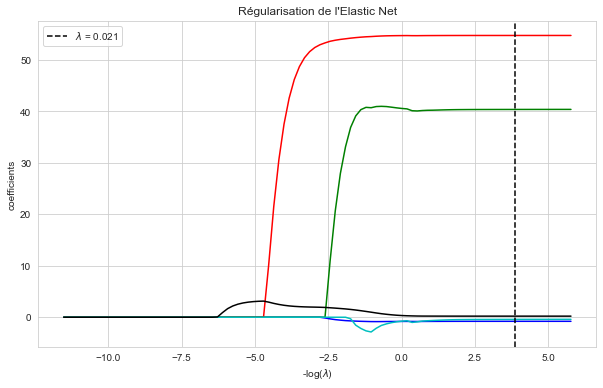

In [28]:
from itertools import cycle
from sklearn.linear_model import enet_path

plt.figure(figsize=(10,6))
eps = 5e-18
alphas_enet, coefs_enet, _ = enet_path(x_train, y_train, eps=eps, l1_ratio=0.99)

colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet[1:6], colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)

plt.axvline(-np.log(0.021), color = 'black', linestyle = '--', label = '$\lambda$ = 0.021')
plt.legend();    
plt.xlabel("-log($\lambda$)");
plt.ylabel("coefficients");
plt.title("Régularisation de l'Elastic Net");

En théorie, nous devrons apercevoir des groupes de covariables apparaître sur le graph. <br>
Cela n'est pas le cas ici car notre <i>ElasticNetCV</i> a estimé $\alpha$ à 0.99, ce qui veut dire que notre modèle se rapproche très fortement d'une régularisation LASSO (le poids du RIDGE étant très faible). <br>
On observe donc ici le phénomène de sparsité du LASSO où les coefficients apparaissent un par un dans le support de $\theta$.

<b>Implémentation de l'Elastic Net</b> <br>
Maintenant que nous avons estimé les paramètres $\lambda$ et $\alpha$, nous pouvons implémenter l'ElasticNet. <br>
Nous allons aussi comparer les coefficients ainsi que la performance de la Régression Classique, du LASSO, du RIDGE et de l'Elastic Net pour prédire nos données <i>y_paris</i>. 

In [29]:
lambda_ = np.arange(0.01,6,0.01)
lasso_comp = LassoCV(cv=5, max_iter = 500, alphas = lambda_, n_alphas = len(lambda_), random_state=0).fit(x_train, y_train)

el_coef_comp = pd.DataFrame({'variable':x_paris.columns, 
                           'Régression':np.round(linear_model.coef_,2), 
                           'LASSO':np.round(lasso_comp.coef_,2),
                           'RIDGE':np.round(ridge_model.coef_,2), 
                           'Elastic Net':np.round(el_cv.coef_,2)})

print(el_coef_comp)
print("")
print(f"Coef LASSO: {np.round(lasso_comp.alpha_,2)}")
print("Coef RIDGE: 0.5")
print(f"Coef Elastic Net: {el_cv.alpha_}, {el_cv.l1_ratio_}")
print("")
print(f"MSE Régression: {np.round(mean_squared_error(y_test,linear_model.predict(x_test)),0)}")
print(f"MSE LASSO: {np.round(mean_squared_error(y_test,lasso_comp.predict(x_test)),0)}")
print(f"MSE RIDGE: {np.round(mean_squared_error(y_test,ridge_model.predict(x_test)),0)}")
print(f"MSE ElasticNet: {np.round(mean_squared_error(y_test,el_cv.predict(x_test)),0)}")

             variable  Régression    LASSO    RIDGE  Elastic Net
0        squareMeters      100.00   100.00   100.00       100.00
1       numberOfRooms       -0.79    -0.80    -0.79         0.24
2              floors       54.76    54.76    54.76        54.54
3       cityPartRange       40.38    39.81    40.38        47.26
4       numPrevOwners       -0.32    -0.00    -0.32        -0.34
5                made       -3.06    -3.01    -3.06        -2.33
6          isNewBuilt      139.75    93.30   139.22       162.99
7   hasStormProtector      119.47    94.81   119.42       141.27
8            basement       -0.01    -0.01    -0.01        -0.00
9               attic       -0.01    -0.01    -0.01        -0.00
10             garage        0.10     0.11     0.10         0.11
11     hasStorageRoom       30.45     6.38    30.44        19.26
12       hasGuestRoom       -9.36    -8.72    -9.36        -5.60
13            hasPool     2964.15  2918.73  2962.81      2979.43
14            hasYard    

L'ElasticNet semble être le meilleur modèle pour prédire le prix d'une maison (<i>price</i> dans ParisPriceHousing) puisque son erreur quadratique moyen est le plus faible. Nous constatons que les erreurs du RIDGE pour prédire le prix sont plus élevé que les erreurs de LASSO. Cela pourrait expliquer pourquoi l'ElasticNet a nettement réduit la part du RIDGE dans le modèle. <br>

Nous pouvons en conclure que l'ElasticNet améliore les performances de la régression linéiare, du LASSO et du RIDGE en tenant compte de la redondance des covariables.
<br>

Il existe d'autres alternatives au LASSO qui prennent en compte la dépendance des covariables (comme le group-lasso par exemple). La différence entre le Group-LASSO et l'ElasticNet est que le Group-LASSO nécessite la connaissance au préalable des groupes de covariables (ce qui n'est pas toujours le cas).
<br>
<br>

# Prédiction par KNN et Régression Logistique (Par Allan Pendant)

Dans le cadre de l'utilisation de modèles de classifications, nous allons essayer de prédire si une résidence est dite luxueuse (category = luxury) ou alors basique (category = basic) en fonction de certaines variables. Deux stratégies de classifications vus en cours seront utilisées : le **KNN** et la **Regression logistique**.

Ici, **la sélection de variables ne sera pas abordée !**

## Chargement des données

In [30]:
housing = pd.read_csv("ParisHousing.csv")
housing.drop(columns = ['Unnamed: 0'], inplace = True)
columns_bool = housing.select_dtypes(bool).columns
housing[columns_bool]  = housing[columns_bool].apply(lambda x : x.astype(int))
from word2number import w2n 
housing['numberOfRooms'] = housing['numberOfRooms'].apply(lambda x : w2n.word_to_num(x))
housing['hasPool'] = housing['PoolAndYard'].str[:8]
housing['hasYard'] = housing['PoolAndYard'].str[12:]
housing.drop(columns = ['PoolAndYard'], inplace = True)
housing['hasPool'] = housing['hasPool'].apply(lambda x : 1 if 'has' in x else 0)
housing['hasYard'] = housing['hasYard'].apply(lambda x : 1 if 'has' in x else 0)

## KNN

L'algorithme **K-NN** est **non-paramétrique** et est applicable dans une étude **supervisée**

Pour une nouvelle observation x, l'estimateur assigne à x le label majoritaire parmi les k plus proches voisins de x. Ces voisins ont été étudié au préalable grace aux données d'entrainements

<u>**Observations sur la variable cible : " hasPool "**</u>

Nous allons essayer de construire le meilleur modèle de prédiction de la variable **" hasPool "**, égale à 1 si oui l'habitation contient une piscine et 0 sinon. Ceci sera fait en fonction de 3 variables : price category hasYard.

In [31]:
housing["hasPool"].value_counts()

0    5032
1    4968
Name: hasPool, dtype: int64

In [32]:
housing["hasPool"].value_counts()/housing["hasPool"].size

0    0.5032
1    0.4968
Name: hasPool, dtype: float64

Nous observons que **les données sont bien équilibrées** pour ces deux modalités.

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [34]:
X = housing[["price", "category","hasYard"]].copy()
y = housing["hasPool"]

X.head()

,price,category,hasYard
0,7559081.5,Basic,0
1,8085989.5,Luxury,1
2,5574642.1,Basic,0
3,3232561.2,Basic,0
4,7055052.0,Luxury,1


In [35]:
X["category"].value_counts()

Basic     8735
Luxury    1265
Name: category, dtype: int64

 - Ici il est nécessaire de **rendre la variable "category" numérique**

In [36]:
mapping = {"Basic" : 0, "Luxury" : 1}
X["category"] = X["category"].apply(lambda x : mapping.get(x))

X.head()

,price,category,hasYard
0,7559081.5,0,0
1,8085989.5,1,1
2,5574642.1,0,0
3,3232561.2,0,0
4,7055052.0,1,1


In [37]:
scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_scaler, y, stratify=y, random_state=2)

Ici nous utilisons l'argument `stratify=y` pour **garder des proportions équitables lors du split**, et l'argument `random_state` pour avoir un controle sur la génération aléatoire.    

Testons le KNN avec le **paramètre K** laissé par défaut (n_neighbors=5).

In [38]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
y_pred = model.predict(X_test)

Maintenant que le model à été entrainé, examinons sa performance

 - Le niveau d'**erreur de Prédiction**:

In [40]:
err_pred = np.sum(abs(y_test - y_pred))/len(y_test)
err_pred

0.4056

- Ce qui donne un niveau **"d'Accuracy"** :

In [41]:
1 - err_pred

0.5944

Affichons la matrice de contingence pour évaluer le niveau de **précision et de sensibilité (recall) :**<br>

- <u>**précision:**</u>

$$P = \frac{VP}{VP + FP}$$

- <u>**recall:**</u>

$$R = \frac{VP}{VP + FN}$$

- <u>**f1:**</u>

$$P = \frac{2*P*R}{P + R}$$

où $VP$ = "vrais positifs", $FP$="faux positifs", $FN$="faux négatifs"

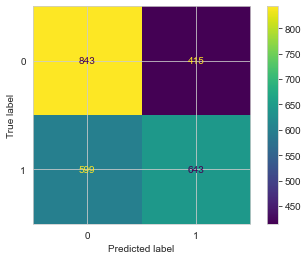

In [42]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test);

In [43]:
precision = 643/(643 + 415)
recall = 643/(643 + 599)
f1 = 2*(precision * recall)/(precision + recall)

In [44]:
print("Precision:", precision)
print("Recall", recall)
print("f1_score:", f1)

Precision: 0.6077504725897921
Recall 0.5177133655394525
f1_score: 0.5591304347826087


<u>**Commentaires**</u>    
Les niveaux de performance ne sont ni haut ni trop bas, maintenant essayons de voir si il est possible d'améliorer le modèle en changeant **le nombre de voisins k** et en utilisant **la validation croisée**.

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [46]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

- **Validation croisée**

On utilise comme type de **scoring f1** pour avoir une idée globale sur le niveau de précision et de sensibilité.

In [47]:
cross_val = cross_val_score(model, X, y, cv=10, scoring="f1")
cross_val

array([0.5723205 , 0.58078141, 0.59623431, 0.565356  , 0.55447681,
       0.55696203, 0.58219895, 0.59354839, 0.55591054, 0.57634409])

In [48]:
performance_moyenne = cross_val.mean()

print("Performance moyenne avec une validation croisée (10-Fold):", performance_moyenne)

Performance moyenne avec une validation croisée (10-Fold): 0.5734133029697955


- **Choix de K**

Voyons quel est le **nombre de voisins K le plus optimal** pour $K\in\{1\dots 20\}$

In [49]:
v1 = []
v2 = []
v3 = []
for i in np.arange(1,21,1):
    model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=i))
    cross_val = cross_val_score(model, X, y, cv=10, scoring="f1")
    v1.append(i)
    v2.append(cross_val.mean())
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    v3.append(np.sum(abs(y_test - y_pred))/len(y_test))
    

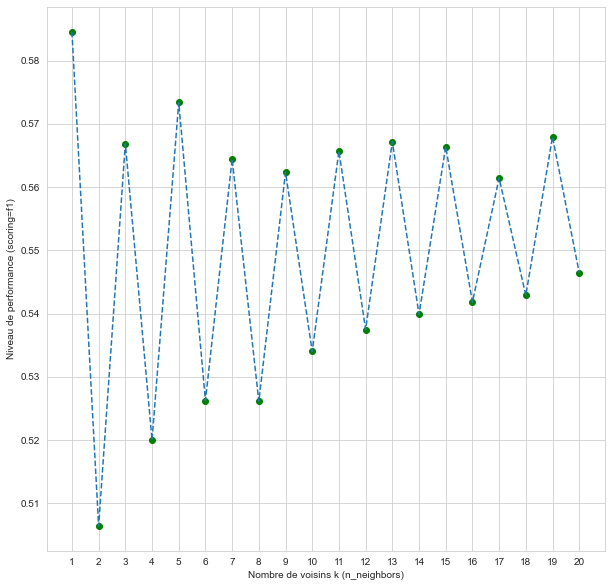

In [50]:
plt.figure(figsize=(10,10));
plt.plot(v1,v2,"--");
plt.scatter(v1,v2,c="green");
plt.xlabel("Nombre de voisins k (n_neighbors)")
plt.ylabel("Niveau de performance (scoring=f1)")
plt.xticks(v1);
plt.grid(True);

Sur ce graphe nous observons que le meilleur niveau de performance est atteint pour **K = 1** et plus généralement, lorsque le nombre de voisins choisis est **impaire**, le niveau de performance se situe **entre 0.56 et 0.60**, tandis que lorsque le nombre de voisins est **paire**, la performance chute (elle se situe **entre 0.50 et 0.55**). Ces niveaux restent tout de même **trop bas pour qualifier ce modèle comme bon**.

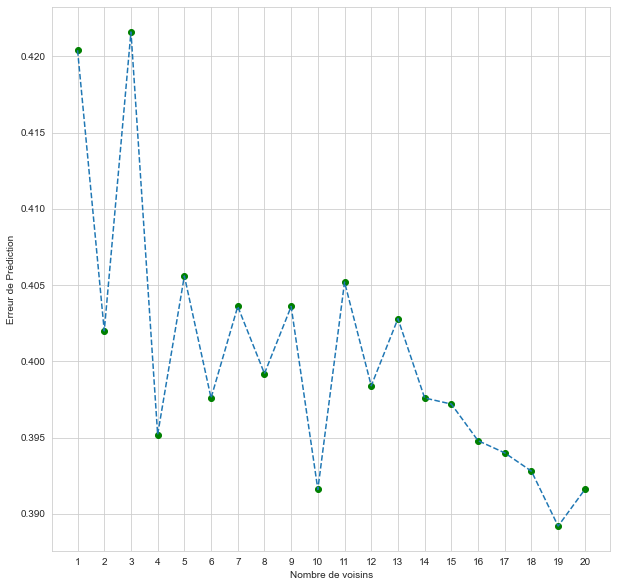

In [51]:
plt.figure(figsize=(10,10));
plt.plot(v1,v3, "--");
plt.scatter(v1,v3,c="green");
plt.ylabel("Erreur de Prédiction")
plt.xlabel("Nombre de voisins")
plt.xticks(v1)
plt.grid(True);

Ici, nous observons qu'en terme d'erreur de prédiction, le niveau d'erreur le plus bas est obtenu pour K = 19. Ce pendant ce critère d'erreur n'est pas le meilleur puisque cela ne nous donne pas d'information sur **le taux de faux positifs ou de faux négatifs** par exemple.

## Regression Logistique

Il serait intéressant de voir si, dans les mêmes conditions, un model de Régression Logistique pourrait être plus performant qu'un modèle basé sur les K-plus proches voisins.

In [52]:
from sklearn.linear_model import LogisticRegression

reg_model = make_pipeline(StandardScaler(), LogisticRegression())
reg_model = LogisticRegression()

In [53]:
reg_model.fit(X_train, y_train)

LogisticRegression()

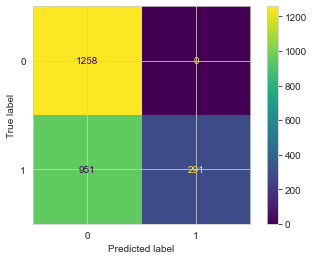

In [54]:
plot_confusion_matrix(reg_model, X_test, y_test);

In [55]:
precision = 291/(291 + 0)
recall = 291/(291 + 951)
f1 = 2*(precision * recall)/(precision + recall)

In [56]:
print("Precision:", precision)
print("recall", recall)
print("f1_score:", f1)

Precision: 1.0
recall 0.23429951690821257
f1_score: 0.37964774951076324


Avec la Régression Logistique, le niveau de **précision** est excellent cependant la **sensibilité** est médiocre.

In [57]:
reg_model = make_pipeline(StandardScaler(), LogisticRegression())
cross_val_reg = cross_val_score(reg_model, X, y, cv=10, scoring="f1")
cross_val_reg

array([0.42222222, 0.43217666, 0.4517134 , 0.3704918 , 0.41467305,
       0.33779264, 0.39418417, 0.43956044, 0.38699187, 0.40257649])

In [58]:
cross_val_reg.mean()

0.40523827327084955

Ces niveaux si faibles pour la régression logistique peut provenir du fait que **ce modele dépend de la loi** de l'échantillon : l'estimateur de la Régression Logistique est calculé par **maximum de vraisemblance**. Tandis que le **KNN** ne dépend d'aucune loi.
<br>
<br>

# GMM ParisHousing sur la variable Price (Par Allan Pendant)

<u>**Contexte**</u>    
Nous sommes ici dans un **cadre non supervisé**, et nous allons voir si il est possible d'obtenir des informations supplémentaires via **une méthode de clustering**.

La méthode des **Mixtures à Mélange Gaussien** repose essentiellement sur **l'hypothèse que nos observations ont été issue de plusieurs distributions gaussiens ayant chacune des paramètres différents**. Appliquer cette méthode revient à **retrouver ces paramètrages de ces supposées distributions**.

In [59]:
variable = housing.loc[:,["price"]]

## Détermination du possible nombre de clusters

Pour déterminer le nombre de clusters nous allons nous fier  à divers critères :
- <u>**le critère AIC**</u>

$$AIC(d) = -2*L_{\beta_d MLE}(x_i^n)  +2d$$
<br>
- <u>**le critère BIC**</u>

$$BIC(d) = -2*L_{\beta_d MLE}(x_i^n) + d*log(n)$$

- <u>**le critère ICL**</u>

$$ICL(d) = -2*L_{\beta_d MLE}(x_i^n) + d*log(n) -ENT$$
où $ENT$ représente l'entropie du modèle

Dans un premier temps, on tente de calculer par nous même ces critères sans utiliser les methodes fournies par scikit-learn.

In [60]:
from sklearn.mixture import GaussianMixture

La fonction GaussianMixture fournie par scikit-learn utilise l'algorithme EM (Expectation-Maximisation) qui globalmeent fonctionne ainsi :

- **Initialisation :** les paramètres des supposées gaussiennes sont générées aléatoirement
- **Etape 1, Expectation :** pour chaque observation de notre base de données, la probabilité d'appartenance à chaqune des gaussiennes est calculée
- **Etape 2, Maximisation :** les paramètres des gaussiennes supposées sont mis à jours en fonction des probabilités calculées lors de l'Expectation et la vraisemblance du modèle est maximisée

Ensuite <u>on réitère les étapes 1 et 2 jusqu'a atteindre un plafond de maximisation de la vraisemblance</u>.

<u>**Tentative de calcul des critères AIC, BIC, ICL à la main :**</u>

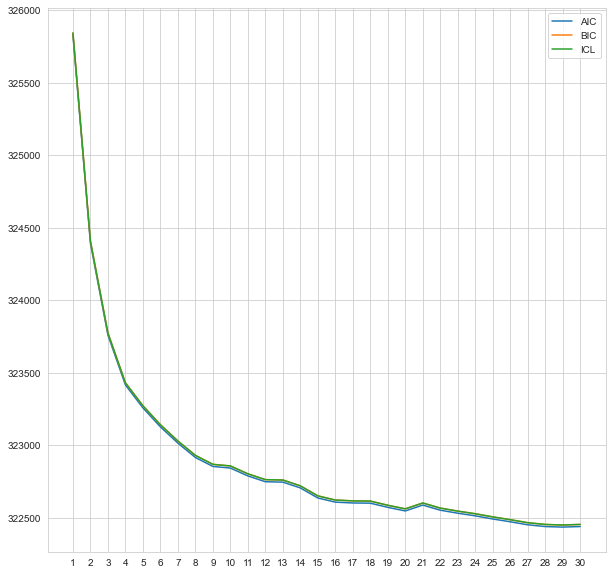

In [61]:
nb_cluster = np.arange(1,31)

y_aic = []
y_bic = []
y_icl = []

for k in range(len(nb_cluster)):
    gmm = GaussianMixture(k + 1, random_state=2).fit(variable)
    
    aic = -2*np.sum(gmm.score_samples(variable)) + 2*2
    y_aic.append(aic)
    
    bic = -2*np.sum(gmm.score_samples(variable)) + 2*np.log(len(variable))
    y_bic.append(bic)
    
    entropy = - np.sum(np.sum(gmm.predict_proba(variable), axis=1))
    y_icl.append(y_bic[k] + entropy)
    
plt.figure(figsize=(10,10));
plt.plot(nb_cluster, y_aic, label="AIC");
plt.plot(nb_cluster, y_bic, label="BIC");
plt.plot(nb_cluster, y_bic, label="ICL");

plt.xticks(nb_cluster)
plt.grid(True)
plt.legend();

Nous observons malheureusment que les trois courbes se chevauchent et décroissent indéfiniemment. Il y a donc des erreurs dans leur implémentation mais si nous tentons tout de même d'en tirer une information, alors nous pouvons appliquer la **méthode du "coude"** et conjecturer que le nombre de clusters est potentiellement **égal à 4**.

<u>**Calcul des critères AIC, BIC (essai pour ICL) :**</u>

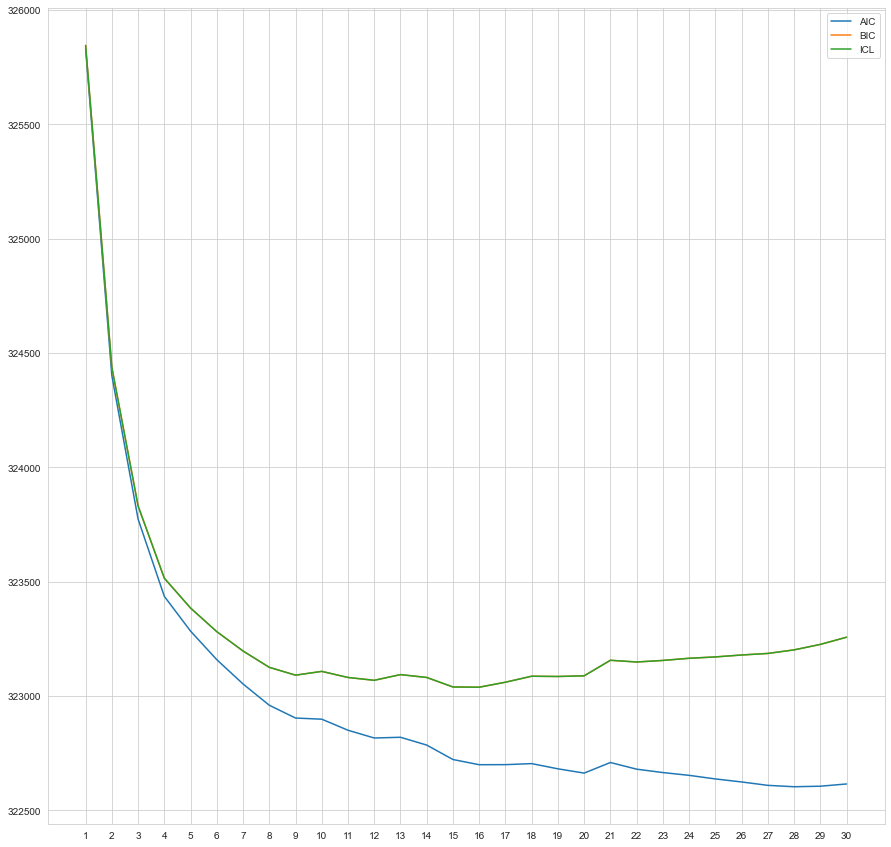

In [62]:
nb_cluster = np.arange(1,31)

y_aic = []
y_bic = []
y_icl = []

for k in range(len(nb_cluster)):
    gmm = GaussianMixture(k + 1, random_state=2).fit(variable)
    
    y_aic.append(gmm.aic(variable))
    y_bic.append(gmm.bic(variable))
    
    entropy = - np.sum(np.sum(gmm.weights_*np.log(gmm.weights_))) #cette formule est fausse mais je ne sais pas comment corriger
    y_icl.append(y_bic[k] + entropy)
    
plt.figure(figsize=(15,15));
plt.plot(nb_cluster, y_aic, label="AIC");
plt.plot(nb_cluster, y_bic, label="BIC");
plt.plot(nb_cluster, y_bic, label="ICL");

plt.xticks(nb_cluster)
plt.grid(True)
plt.legend();

<u>Sur ce graph, nous observons :</u> <br>
- que le **critère AIC** continue de décroitre, en effet c'est un phénomène connu : le Critère AIC a toujours tendance à sélectionner les modèles (ou paramètres) les plus grands ce qui revient ici à choisir le nombre de clusters le plus grand possible.

- Le  **critère BIC** admet un minimum global à 15

- L'implémentation du **critère ICL** n'est pas bon car il chevauche celui du critère BIC

Idéalement c'est le critère ICL qui serait à privilégier pour répondre à notre problème. Mais Nous pouvons malgré tout nous fier au critère BIC. Cependant nous n'allons pas fixer à 15 le nombre de clusters car nous le jugeons trop grand et nous allons allons une nouvelle fois appliquer la **méthode du "coude"**.<br>

Nous arrivons ainsi à la même conclusion que précédemment, à savoir que <u><b>le nombre de clusters possibles semble être égal à 4</b></u>.

<u>Voyons maintenant ce que cela donne graphiquement:</u>

In [63]:
gmm = GaussianMixture(4, random_state=2)
gmm.fit(variable)
variable["labels"] = gmm.predict(variable)
variable

,price,labels
0,7559081.5,1
1,8085989.5,1
2,5574642.1,2
3,3232561.2,3
4,7055052.0,2
...,...,...
9995,176425.9,0
9996,4448474.0,3
9997,8390030.5,1
9998,5905107.0,2


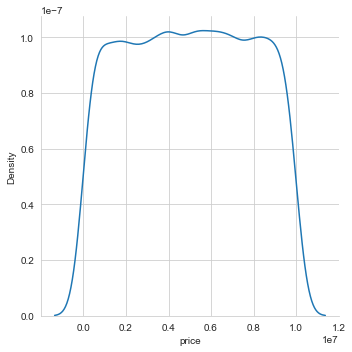

In [64]:
sns.displot(data=variable, x="price", kind="kde");

Et ici affichons les supposées distributions gaussiennes dont seraient originaires les donéees :

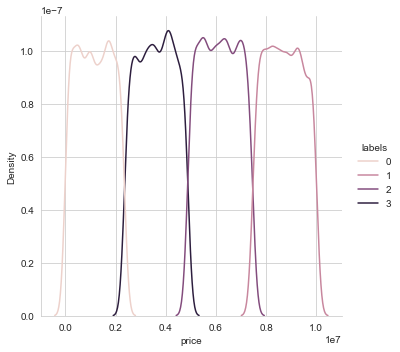

In [65]:
sns.displot(data=variable, x="price", kind="kde", hue="labels");

Le résultat ici n'est pas très satisfaisant, nous voyons que si les données ont réellement été générées par des distribution gaussiennes alors le nombre de clusters réel semble être supérieur à 4.

Voyons les paramètres des gaussiennes calculées:

In [66]:
gmm.means_

array([[1221360.81213688],
       [8666777.71218181],
       [6149593.25477456],
       [3645352.3319847 ]])

In [67]:
gmm.covariances_

array([[[5.93355389e+11]],

       [[6.74706135e+11]],

       [[8.86282469e+11]],

       [[8.41976166e+11]]])

<br>
<br>

# Arbres de decision et Random Forest (Par Safa Hamdan)

Dans cette partie, nous allons travailler sur deux algorithmes : l'arbre de décision et le Random Forest qui sont deux algorithmes d'aide à la décision qui se basent sur les préditions faites par le modèle.
Il y a deux approches pour construire ces algorithmes, soit nous fournir des prédictions par regression ou par classification :

   - <u>par classification</u> : va chercher à prédire une variable cible en analysant les classes prédéfinies des autres variables du modèle et est plus adapté pour des variables discrètes
   - <u>par régression</u> : va chercher à prédire une variable cible en analysant le comportement passé des autres variables du modèle et est plus adapté pour des variables continues.
   
Pour le jeu de données, nous avons choisi (ParisHousing), nous avons décidé de faire des modeles de classification car nous souhaitions prédire une variable catégorielle : 'HasYard'. Mais si nous aurions choisi de prédire la variable 'price' ou 'cityCode', nous aurions privilégié des modèles de régressions.
<br>
<br>

## Arbre de décision

La mécanique d'un arbre de décision est plutôt simple, partons de l'hypothèse que nous avons un arbre de décision binaire :

   - étape 1 - Noeud parent : sélectionner une variable explicative $X_j$ (ou classe) qui donnera "le meilleur résultat" à l'étape suivante.
   - étape 2 - Noeuds enfants : sélectionner un seuil $s$ qui puisse determiner un "meilleur résultat".
    
À partir de là, deux régions sont formées, une qui désignera la probabilité d'être en dessous ($R^+_j$) du seuil et au dessus($R^-_j$) tel que :

$$R^+_j=\{X_j \leq s\} \ et \ R^-_j=\{X_j> s\}$$

Chacune de ces régions sont appelées "noeuds enfants" de l'itération précédente et deviendrons des "sous neouds parents", sauf si celles-ci représentent les feuilles de l'arbre, donc sont les noeuds enfants de la dernière itération.

Notons que dans le cas d'un arbre de décision non-binaire, nous aurions autant de régions que de catégories présentes dans la variable cible.

Dans un cadre parfait, chacunes des feuilles de l'arbre ne contiendraient qu'une classe distincte, mais comme tout cadre parfait, il est difficilement atteignable, mais nous pouvons essayer d'obtenir des résultats corrects.

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
#import sys
#!{sys.executable} -m pip install pandas_profiling
#import pandas_profiling

In [69]:
Housing = pd.read_csv("ParisHousing.csv",index_col=False)
Covid = pd.read_csv("Covidcases.csv",index_col=False)
Housing.head()

,Unnamed: 0,squareMeters,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category,PoolAndYard
0,0,75523,three,63,9373,3,8,2005,False,True,4313,9005,956,False,7,7559081.5,Basic,has pool and no yard
1,1,80771,thirty-nine,98,39381,8,6,2015,True,False,3653,2436,128,True,2,8085989.5,Luxury,has pool and has yard
2,2,55712,fifty-eight,19,34457,6,8,2021,False,False,2937,8852,135,True,9,5574642.1,Basic,has pool and no yard
3,3,32316,forty-seven,6,27939,10,4,2012,False,True,659,7141,359,False,3,3232561.2,Basic,no pool and no yard
4,4,70429,nineteen,90,38045,3,7,1990,True,False,8435,2429,292,True,4,7055052.0,Luxury,has pool and has yard


### Choix du dataset 

   Ici nous avons deux choix, travailler sur les statistiques total (morts au total, cas au total etc..) du Covid-19 en Asie, ou travailler les prix des appartements à Paris qui a l'air d'être un dataset généré aléatoirement.<br>

Les deux datasets présentent certains soucis, mais celui du Covid un peu plus sachant que nous n'avons pas assez de données pour prédire quoi que ce soit de concret. De plus le dataset Covid n'a que des variables catégorielles avec un nombre de catégories trop élevé.<br>

Nous allons donc privilégier le dataset ParisHousing malgré le fait qu'il ait été généré aléatoirement. Le problème est qu'il y a une possibilité de ne pas obtenir de bon résultats dû à l'arrangement des données, mais nous avons assez de lignes et de variables catégorielles intéressantes pour produire des résultats correctes.

<b> Modifions un peu le dataset </b> <br>
Comme les variables sont plutôt explicites, nous n'allons pas définir chacunes d'entre elles dans le détails et nous allons passer directement à la modification du dataset Housing :

- "numberOfRooms" est composé de strings qui correspondent à des chiffres (chiffres en texte -> valeurs numériques)
- "hasStormProtector", "hasStoargeRoom" et "isNewBuilt" sont des variables composées de booléans (True/False à transformer en Vrai/Faux)
- "category" et "PoolAndYard" sont des variables de types object qui doivent être transformées en variables booléennes (O ou 1)

Nous faisons ceci pour aider les modèles à comprendre les différentes classes existantes.

In [70]:
#!pip install word2number
from word2number import w2n 

columns_bool = Housing.select_dtypes(bool).columns
Housing[columns_bool]  = Housing.select_dtypes(bool).apply(lambda x : x.astype(int))

Housing['numberOfRooms'] = Housing['numberOfRooms'].apply(lambda x : w2n.word_to_num(x))

Housing['hasPool'] = Housing['PoolAndYard'].str[:8]
Housing['hasYard'] = Housing['PoolAndYard'].str[12:]
Housing.drop(columns = ['PoolAndYard'], inplace = True)
Housing['hasPool'] = Housing['hasPool'].apply(lambda x : 1 if 'has' in x else 0)
Housing['hasYard'] = Housing['hasYard'].apply(lambda x : 1 if 'has' in x else 0)
OneHot = OneHotEncoder(sparse=False) 
new_ = OneHot.fit_transform(Housing['category'].values.reshape(-1,1))
feature_names = OneHot.get_feature_names(input_features=['category'])
Housing[feature_names] = pd.DataFrame(new_, columns =  (feature_names))
Housing.drop(columns = ['category', 'Unnamed: 0'], inplace = True)

Housing

,squareMeters,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,hasPool,hasYard,category_Basic,category_Luxury
0,75523,3,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,1,0,1.0,0.0
1,80771,39,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1,1,0.0,1.0
2,55712,58,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,1,0,1.0,0.0
3,32316,47,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,0,0,1.0,0.0
4,70429,19,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9,1,0,1.0,0.0
9996,44403,29,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0,1,1,1.0,0.0
9997,83841,3,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5,0,0,1.0,0.0
9998,59036,70,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0,0,0,1.0,0.0


### Sélection de variables

Nous allons maintenant utiliser deux indicateurs pour estimer quelles variables choisir pour notre modèle :

  - la matrice de corrélation qui va nous permettre de savoir quelles variables sont corrélées entre elles. Si deux variables sont trop corrélées positivement ou négativement, alors nous pouvons exprimer l'une par rapport à l'autre et donc en supprimer une de notre modèle.
  - la méthode de sélection par variance qui va calculer la variance de la distribution de chacune de nos variables et va supprimer toutes celles qui ont une variance inférieur au seuil qu'on fixe à la fonction.
  
La raison pour laquelle il est important de faire ces sélections est pour éviter d'avoir trop de variables explicatives et donc de potentiellement overfitter le modèle.

<b> Matrice de corrélation </b>

<AxesSubplot:>

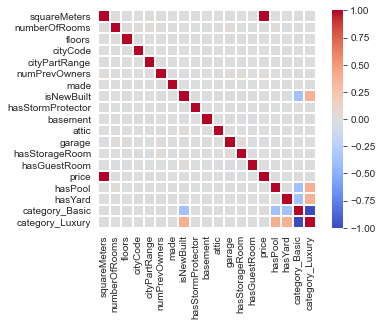

In [71]:
cor = Housing.corr() 
sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.1 )

On remarque que mise à part 'price' / 'squareMeters' et 'category_Basic' / 'category_Luxury', les autres variables ne sont pas réellement corrélées. ayant pris connaissance de ceci, nous pouvons maintenant choisir une variable cible maintenant, en privilégiant les variables binaires, assez bien équilibré et qui ne présentent pas trop de corrélation avec d'autres variables :

In [72]:
print(Housing.groupby('hasYard')['hasYard'].count()/10000)
print(Housing.groupby('hasPool')['hasPool'].count()/10000)
print(Housing.groupby('isNewBuilt')['isNewBuilt'].count()/10000)
print(Housing.groupby('hasStormProtector')['hasStormProtector'].count()/10000)
print(Housing.groupby('hasStorageRoom')['hasStorageRoom'].count()/10000)

hasYard
0    0.4913
1    0.5087
Name: hasYard, dtype: float64
hasPool
0    0.5032
1    0.4968
Name: hasPool, dtype: float64
isNewBuilt
0    0.5009
1    0.4991
Name: isNewBuilt, dtype: float64
hasStormProtector
0    0.5001
1    0.4999
Name: hasStormProtector, dtype: float64
hasStorageRoom
0    0.497
1    0.503
Name: hasStorageRoom, dtype: float64


On remarque que toutes les variables sont bien équilibrées, faisons donc un choix arbitraire, prenons 'hasYard' comme variable target.

<b>Sélection par variance </b><br>

Nous devons maintenant sélectionner les variables explicatives du modèles. La méthode de sélection par variance permet de calculer la variance de chacune des caractèristiques et retire celle qui n'atteigne pas le seuil demandé. Ici il est de 0.5, ce qui est le seuil par défaut qui donne un nombre correcte de varibles.

In [73]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

selection = variance_threshold_selector(Housing.drop(['squareMeters','hasPool','category_Basic','hasYard'],axis=1),threshold=0.5)
selection.head()

,numberOfRooms,floors,cityCode,cityPartRange,numPrevOwners,made,basement,attic,garage,hasGuestRoom,price
0,3,63,9373,3,8,2005,4313,9005,956,7,7559081.5
1,39,98,39381,8,6,2015,3653,2436,128,2,8085989.5
2,58,19,34457,6,8,2021,2937,8852,135,9,5574642.1
3,47,6,27939,10,4,2012,659,7141,359,3,3232561.2
4,19,90,38045,3,7,1990,8435,2429,292,4,7055052.0


Construisons maintenant notre modèle

In [74]:
feature_cols=list(selection.columns.values.tolist())
X = Housing[feature_cols]
y = Housing.hasYard

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

### Construction de l'arbre de décision

   Maintenant que nous avons construit notre modèle, nous pouvons créer notre arbre de décision, mais pour cela nous avons besoin de choisir un critère de sélection.<br>

<b>Critères : Gini index et entropy</b><br>
    Il y a deux critères possible pour construire l'arbre de decision qui permet à l'arbre de fixer le seuil $s$ vu plus haut. Ces deux critères permettent de mesurer le degrés d'homogénéité, ou la "pureté" de l'information apportée pour chaque noeud pour pouvoir expliquer la variable cible par toutes les classes distinctes (et donc obtenir les feuilles les plus "pures" possibles). <br>
    
- L'indice de Gini : C'est un indice se trouvant toujours entre [0,0.5] et mesure la probabilité de mal identifier un élément choisi au hasard par le modèle. 

$$Indice \ de \ Gini \ = \ 1 - \sum_{j} p_j^2$$

   avec $p_j$ la probabilité de tomber sur un des éléments.

- L'entropie : L'entropie est un indice se trouvant toujours entre [0,1] et va mesurer le degré d'homogénéité d'un élément à chaque division. 

$$Entropie \ = \ -\sum_{j}p_jlog_2(p_j) $$

   avec $p_j$ la probabilité de tomber sur un des éléments. 

Notons que pour les deux critères, plus le coefficient est élevé, plus la probabilité d'avoir correctement identifié un élément dans une classe est élevé.<br>
On remarque que le critère d'entropie est plus coûteux, notamment de par son logarithme de base 2, c'est pourquoi on préfèra l'indice de Gini comme critère.

### Sélection des paramètres

Nous allons chercher les meilleurs coefficients de deux paramètres en particulier : max_depth et min_samples_leaf. Il existe plusieurs paramètres pouvant améliorer le modèle s'ils sont bien choisis, mais nous allons nous contenter de cela par facilité et pour alléger le code, tout en optimisant l'algorithme et nous allons expliquer pourquoi.

   - <b> Sélection de la profondeur maximale de l'arbre</b><br>
Maintenant que nous avons choisi un critère, pour choisir le nombre de noeud maximal que peut produire l'arbre, nous allons calculer, pour k=[1,100], le score de la base de données test et de la base de données train.<br>
Nous nous attendons à observer une augmentation plus ou moins rapide pour les données d'entrainement et des resultats moyen voir faible pour les données test.<br>

   Nous faisons ceci pour éviter d'overfitter le modèle. En effet le modèle est overfitté lorsque l'écart entre le score des données d'entraînement et celui des données test est très grand. C'est pourquoi nous voulons chercher le paramètre (ici max_depth) le plus grand pour lequel cet écart est le plus petit.<br>

   Ici nous cherchons spécifiquement le paramètre le plus grand car plus l'arbre est profond, plus il sera "pure" et donc mieux sera expliqué la variable cible.

In [76]:
trained_score=[]
test_score=[]
for k in range(1,100):
    dtclf = DecisionTreeClassifier(criterion="gini", max_depth=k,random_state=0)

    # Train Decision Tree Classifer
    dtclf = dtclf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = dtclf.predict(X_test)
    
    trained_score.append(dtclf.score(X_train, y_train))
    test_score.append(dtclf.score(X_test, y_test))

(0.0, 10.0)

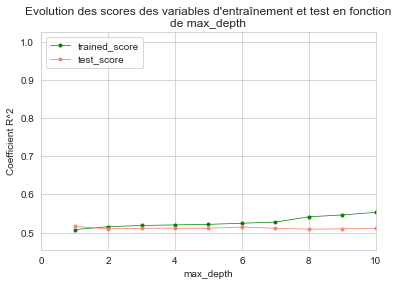

In [77]:
from textwrap import wrap
R=range(1,100)
plt.plot(R, trained_score, linewidth=0.7,marker='.', color='green',label='trained_score')
plt.plot(R, test_score, linewidth=0.8,marker='.', color='salmon',label='test_score')

plt.legend(loc="upper left")
plt.title('\n'.join(wrap('Evolution des scores des variables d\'entraînement et test en fonction de max_depth')))
plt.xlabel('max_depth')
plt.ylabel('Coefficient R^2')

plt.xlim(0, 10)

In [78]:
dtclf = DecisionTreeClassifier(criterion="gini", max_depth=7,random_state=0)

# Train Decision Tree Classifer
dtclf = dtclf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtclf.predict(X_test)

print("Score test:",dtclf.score(X_test, y_test))
print("Score train:",dtclf.score(X_train, y_train))
print("Ecart score train et score test :",dtclf.score(X_train, y_train)-dtclf.score(X_test, y_test))
recall_score(y_test,y_pred,average="weighted")

Score test: 0.511
Score train: 0.5275714285714286
Ecart score train et score test : 0.01657142857142857


0.511

In [79]:
dtclf = DecisionTreeClassifier(criterion="gini", max_depth=5,random_state=0)

# Train Decision Tree Classifer
dtclf = dtclf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtclf.predict(X_test)

print("Score test:",dtclf.score(X_test, y_test))
print("Score train:",dtclf.score(X_train, y_train))
print("Ecart score train et score test :",dtclf.score(X_train, y_train)-dtclf.score(X_test, y_test))
recall_score(y_test,y_pred,average="weighted")

Score test: 0.5113333333333333
Score train: 0.5215714285714286
Ecart score train et score test : 0.010238095238095268


0.5113333333333333

Visuellement, on repère 2 points intéressants : max_depth=5 et max_depth=7.Ici on remarque, qu'à accuracy égale, le paramètre qui minimise l'écart entre les deux scores est max_deapth = 5, nous allons donc choisir max_depth=5.

   - <b> Sélection du paramètre  min_samples_leaf de l'arbre</b><br>
Nous allons maintenant essayer de définir un coéfficient pour le paramètre min_samples_leaf. En fonction du coefficient, ce paramètre va essayer de reduire le nombre d'échantillons utilisés dans les feuilles. <br>

   De manière général, même s'il n'y a pas de règles fixé, plus le nombre d'échantillon est faible dans les feuilles, plus la probabilité que le degré d'homogénéité entre les classes soit faible est grand, ce qui signifie que chaque feuilles représente strictement une classe, ce qui est le but de notre modèle.

In [80]:
trained_score=[]
test_score=[]
diff=[]
for k in range(1,100):
    dtclf = DecisionTreeClassifier(criterion="gini", max_depth=5,min_samples_leaf=k,random_state=0)

    # Train Decision Tree Classifer
    dtclf = dtclf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = dtclf.predict(X_test)
    
    trained_score.append(dtclf.score(X_train, y_train))
    test_score.append(dtclf.score(X_test, y_test))
    diff.append(dtclf.score(X_train, y_train)-dtclf.score(X_test, y_test))

(30.0, 40.0)

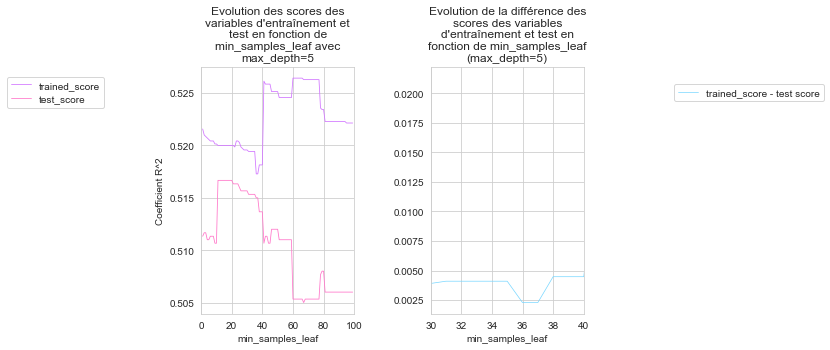

In [81]:
R=range(1,100)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)

ax2.plot(R, diff, linewidth=0.7, color='#78D7FF',label='trained_score - test score')
ax1.plot(R, trained_score, linewidth=0.8, color='#D278FF',label='trained_score')
ax1.plot(R, test_score, linewidth=0.8, color='#FF78CA',label='test_score')

ax2.legend(bbox_to_anchor=(2.6, 0.95))
ax1.legend(bbox_to_anchor=(-0.6, 0.98))
ax1.title.set_text('\n'.join(wrap('Evolution des scores des variables d\'entraînement et test en fonction de min_samples_leaf avec max_depth=5',30)))
ax2.title.set_text('\n'.join(wrap('Evolution de la différence des scores des variables d\'entraînement et test en fonction de min_samples_leaf (max_depth=5)',33)))
ax1.set_xlabel('min_samples_leaf')
ax2.set_xlabel('min_samples_leaf')
ax1.set_ylabel('Coefficient R^2')

ax1.set_xlim(0,100)
ax2.set_xlim(30,40)

On observe que l'écart le plus petit à l'air de se situer entre min_samples_leaf =30 et 40. En ne sélectionnant que min_samples_leaf $\in [30,40]$ sur le graph de la différence des scores, on voit que le minimum global se situe quand min_samples_leaf=36. Nous avons donc notre modèle final :

In [82]:
dtclf = DecisionTreeClassifier(criterion="gini", max_depth=5,min_samples_leaf=36,random_state=0)

# Train Decision Tree Classifer
dtclf = dtclf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtclf.predict(X_test)

print("Score test:",dtclf.score(X_test, y_test))
print("Score train:",dtclf.score(X_train, y_train))
print("Ecart score train et score test :",dtclf.score(X_train, y_train)-dtclf.score(X_test, y_test))
recall_score(y_test,y_pred,average="weighted")

Score test: 0.515
Score train: 0.5172857142857142
Ecart score train et score test : 0.0022857142857142243


0.515

Représentons maintenant notre modèle par un graph :

In [83]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [92]:
dot_data = StringIO()
export_graphviz(dtclf, out_file=dot_data,  
                filled=True, rounded=True,proportion=True,feature_names = feature_cols,class_names=['Has no yard','Has yard'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Yard_DT.png')
Image(graph.create_png())

InvocationException: GraphViz's executables not found

Les observations seront fournies plus tard...
<br>
<br>

## Random Forest

Regardons d'un peu plus près le Random forest maintenant mais parlons d'abord des algorithmes de Bagging. Leur mécanisme implique de partir d'un premier jeu de données puis de suivre différentes étapes :

   - étape 1 : génère $A_i$ "sous-échantillons" du jeu de données initial, tous indépendants les uns des autres.
   - étape 2 : il va ensuite entraîner chaque modèles de manière indépendantes, tel des arbres de décisions basiques.
   - étape 3 : puis finalement entraîner le modèle final sur les résultats trouvés pour chaque arbres $A_i$ précédents.
   
Le Random Forest est un hybride du Bagging mais à tirage aléatoire. En effet, pour créer chaque arbre de l'étape 1, le Random Forest va d'abord tirer au sors de manière aléatoire un nombre m de variables explicatives parmis les k disponibles, puis va tester quelles variables donnent les meilleurs résultats pour créer les différents noeuds puis va renvoyer un "sous-échantillon" ainsi.

On suppose de par la compléxité du modèle, que de manière général, le Random Forest est plus performant que l'arbre de décision.

### Création du modèle 

<b> Sélection des paramètres </b><br>

La fonction RandomForestClassifier est très analogue à DecisionTreeClassifer à l'exception d'un paramètre qui est n_estimators.
Ce paramètre représente le "nombre d'arbre dans la forêt" donc le nombre "i" d'arbres $A_i$ à choisir pour entraîner notre modèle final. C'est un paramètre important, nous allons donc implémenter la recherche de son coefficient, comme vu précédement. Nous allons néanmoins fixer max_depth=5 pour pouvoir comparer nos deux algorithmes.

In [85]:
trained_score=[]
test_score=[]
diff=[]
for k in range(50,200):
    rfclf = RandomForestClassifier(criterion="gini", max_depth=5,n_estimators=k,random_state=0)

    # Train Decision Tree Classifer
    rfclf = rfclf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = rfclf.predict(X_test)
    
    trained_score.append(rfclf.score(X_train, y_train))
    test_score.append(rfclf.score(X_test, y_test))
    diff.append(rfclf.score(X_train, y_train)-rfclf.score(X_test, y_test))

(150.0, 200.0)

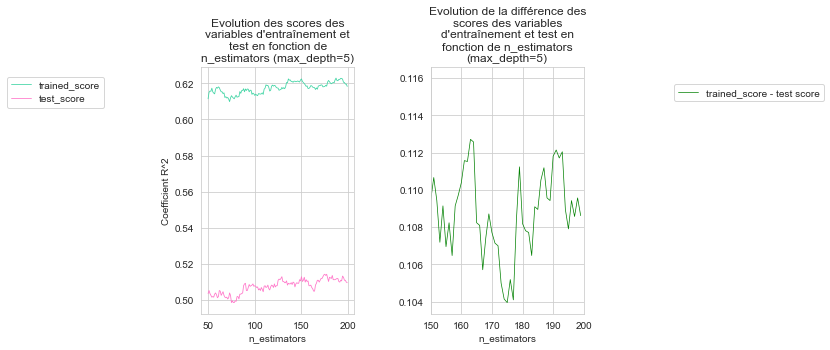

In [86]:
R=range(50,200)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)

ax2.plot(R, diff, linewidth=0.7, color='green',label='trained_score - test score')
ax1.plot(R, trained_score, linewidth=0.8, color='#42D5A5',label='trained_score')
ax1.plot(R, test_score, linewidth=0.8, color='#FF78CA',label='test_score')

ax2.legend(bbox_to_anchor=(2.6, 0.95))
ax1.legend(bbox_to_anchor=(-0.6, 0.98))
ax1.title.set_text('\n'.join(wrap('Evolution des scores des variables d\'entraînement et test en fonction de n_estimators (max_depth=5)',30)))
ax2.title.set_text('\n'.join(wrap('Evolution de la différence des scores des variables d\'entraînement et test en fonction de n_estimators (max_depth=5)',33)))
ax1.set_xlabel('n_estimators')
ax2.set_xlabel('n_estimators')
ax1.set_ylabel('Coefficient R^2')

plt.xlim(150, 200)

On remarque visuellement (surtout car nous avons tracé la courbe des différences de scores) que le meilleur n_estimators se trouve entre 150 et 200 et quand on observe de plus près, on voit que le minimum global est atteint à x=175.

   - <b> Sélection de la min_samples_leaf de l'arbre</b><br>

In [87]:
trained_score=[]
test_score=[]
diff=[]
for k in range(1,100):
    rfclf = RandomForestClassifier(criterion="gini", max_depth=5,n_estimators=175,min_samples_leaf=k,random_state=0)

    # Train Decision Tree Classifer
    rfclf = rfclf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = rfclf.predict(X_test)
    
    trained_score.append(rfclf.score(X_train, y_train))
    test_score.append(rfclf.score(X_test, y_test))
    diff.append(rfclf.score(X_train, y_train)-rfclf.score(X_test, y_test))

(90.0, 100.0)

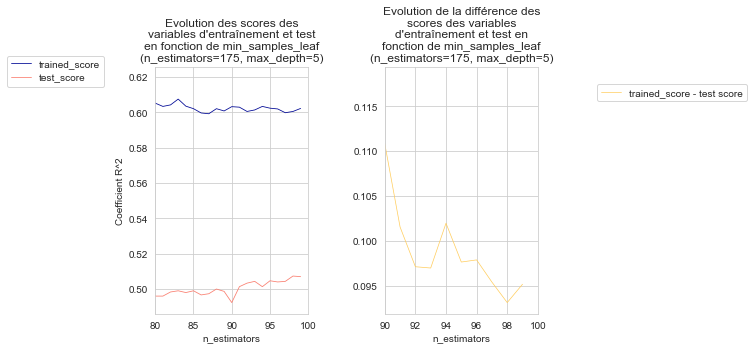

In [88]:
R=range(1,100)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)

ax2.plot(R, diff, linewidth=0.7, color='#FFCD5C',label='trained_score - test score')
ax1.plot(R, trained_score, linewidth=0.8, color='#000895',label='trained_score')
ax1.plot(R, test_score, linewidth=0.8, color='salmon',label='test_score')

ax2.legend(bbox_to_anchor=(2.4, 0.95))
ax1.legend(bbox_to_anchor=(-1, 0.9))
ax1.title.set_text('\n'.join(wrap('Evolution des scores des variables d\'entraînement et test en fonction de min_samples_leaf (n_estimators=175, max_depth=5)',32)))
ax2.title.set_text('\n'.join(wrap('Evolution de la différence des scores des variables d\'entraînement et test en fonction de min_samples_leaf (n_estimators=175, max_depth=5)',33)))
ax1.set_xlabel('n_estimators')
ax2.set_xlabel('n_estimators')
ax1.set_ylabel('Coefficient R^2')

ax1.set_xlim(80,100)
ax2.set_xlim(90,100)

On remarque, visuelement, que la différence entre les deux score est la plus faible pour min_samples_leaf=98. Nous avons donc notre modèle final :

In [89]:
rfclf = RandomForestClassifier(max_depth=5,n_estimators=70,max_features='auto',min_samples_leaf=98,random_state=0)

rfclf = rfclf.fit(X_train,y_train)

y_pred = rfclf.predict(X_test)

estim=rfclf.estimators_[2]

print("Score test:",rfclf.score(X_test, y_test))
print("Score train:",rfclf.score(X_train, y_train))
print("Ecart score train et score test :",rfclf.score(X_train, y_train)-rfclf.score(X_test, y_test))
recall_score(y_test,y_pred, average="weighted")

Score test: 0.5146666666666667
Score train: 0.5962857142857143
Ecart score train et score test : 0.08161904761904759


0.5146666666666667

Représentons maintenant notre modèle par un graph:

In [90]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

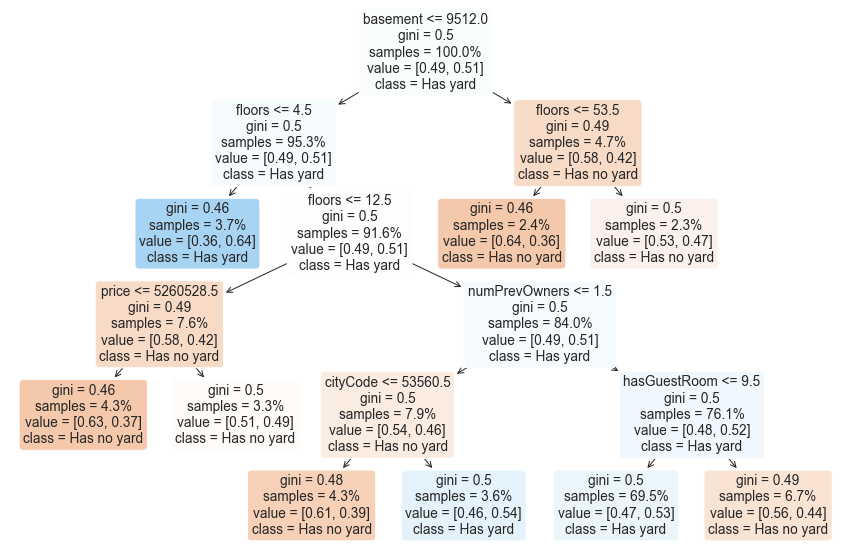

In [91]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15, 10))
plot_tree(estim,  
                filled=True, rounded=True, proportion = True, 
                precision = 2,feature_names = feature_cols,class_names=['Has no yard','Has yard'])
fig.savefig('randomforest.png')

### Observations et conclusion

La première chose à noter est que dans le cas de notre dataset, il s'avère qu'il est plus facile de sur-évaluer l'algorithme Random Forest que l'arbre de décision. <br>
La deuxième observation serait que malgré des profondeurs maximal identiques, l'arbre trouvé avec le Random Forest est beaucoup moins complèxe que celui de l'arbre de decision alors que nous avons un accuracy égal.

Nous l'avons dit plus haut, de manière général, nous savons que le Random Forest performe mieux que l'arbre de décision et c'est ainsi que nous pouvons le constater dans notre cas. Malheureusement, notre dataset (qui est généré aléatoirement) ne permet pas d'observer la puissance du Random Forest, tel qu'elle est décrite dans la littérature, en montrant ses performances sur l'accuracy et ses capacités à pouvoir éviter l'overfitting.

Mais une chose qui est intéréssante de noter et qu'on ne trouve pas souvent dans les articles est que le Randome forest produit des résultats plus clair et plus lisible que l'arbre de décision. Nous avons souvent parlé de l'importance du nombres d'echantillons utilisé pour prédire les feuilles, et on voit que, même si les "samples" sont plus petit sur les feuilles de l'arbre de décision, ils sont quand même suffisament petit dans le Random Forest pour valider d'un degré de pureté correct pour chaques feuilles.